In [ ]:
# 将无线频段分为30段 每段取PSD均值、方差、PSD差分均值三个特征 共30*3个特征(同时生成训练数据与测试数据)

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
#对采集的数据分组取均值
def get_train_data_n(path):
    data_mean = pd.DataFrame()
    n_sum = 400
    n_mean = 40
    for j in range(n_sum/n_mean):
        data_sa = pd.DataFrame()
        for i in range(n_mean*j+1,n_mean*(j+1)+1):
            path_x = path+str(i/100)+str((i%100)/10)+str((i%100)%10)+'.csv'
            sa = pd.read_csv(path_x,header=None)
            sa.columns=['fre','pow'+str(i)]
            del sa['fre']
            data_sa = pd.concat([data_sa,sa],axis=1)
        data_sa = 10**(data_sa/10)
        mean=data_sa.mean(axis=1)
        mean=mean.map(lambda x :math.log(x,10)*10)
        data_mean['pow_mean_'+str(j)] = mean
    return data_mean

In [3]:
def get_train_data_y(path):
    data_mean = pd.DataFrame()
    n_sum = 400
    n_mean = 40
    for j in range(n_sum/n_mean):
        data_sa = pd.DataFrame()
        for i in range(n_mean*j+1,n_mean*(j+1)+1):
            path_x = path+str(i/100)+str((i%100)/10)+str((i%100)%10)+'.csv'
            sa = pd.read_csv(path_x,header=None)
            sa.columns=['fre','pow'+str(i)]
            del sa['fre']
            data_sa = pd.concat([data_sa,sa],axis=1)
        data_sa = 10**(data_sa/10)
        mean=data_sa.mean(axis=1)
        mean=mean.map(lambda x :math.log(x,10)*10)
        data_mean['pow_mean_'+str(j)] = mean
    return data_mean

In [4]:
# 用于平滑的函数
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [5]:
# 取差值（斜率）作为特征
def cha(df):
    n=df.shape[1]
    ret = pd.DataFrame()
    for i in range(n-1):
        d=df.iloc[:,i+1]-df.iloc[:,i]
        ret[i]=d
    ret[n-1]=0
    return ret

In [6]:
# 取PSD特征
def psd_feature(df):
    m=df.shape[1]
    n=100   #每100个频点作为一个子带
    signal_feature = pd.DataFrame()
    for i in range(m/n):
        df_n=df.iloc[:,range(n*i,n*(i+1))]
        df_n = 10**(df_n/10)
        mean=df_n.mean(axis=1)
        var = df_n.var(axis=1)
        mean=mean.map(lambda x :math.log(x,10)*10)
        signal_feature['psd_mean_'+str(i)] = mean
        signal_feature['psd_var_'+str(i)] = var
    return signal_feature

In [7]:
# 取PSD差分特征
def psd_cha_feature(df):
    m=df.shape[1]
    n=100
    signal_feature = pd.DataFrame()
    for i in range(m/n):
        df_n=df.iloc[:,range(n*i,n*(i+1))]
        mean=df_n.mean(axis=1)    # mean 代表该频段的平均上升下降次数
        mean=mean.map(lambda x:0 if x>-0.5 else 1) # 二次离散化
        signal_feature['psd_cha_'+str(i)] = mean
    return signal_feature

In [8]:
def smooth(df):
    for i in range(len(df)):
        y = df.ix[i].values
        yhat = savitzky_golay(y, 101, 3)
        df.ix[i]=yhat
    return df

In [9]:
def convert_data(sa):
    if sa<=-89.5:    #重要！！
        return 0
    else:
        return 1

In [10]:
def convert_cha(sa):
    if (sa>0):
        return 1
    else:
        return -1

In [11]:
def convert_var(sa):
    if (sa>1e-20):
        return 1
    else:
        return 0

In [12]:
# 用于训练和验证的数据集路径
path_n=['./0908/NO/GL/2455/NO_SA_2455_20_5000_00','./0711/N/SA/SA2415/SA00','./0711/N/SA/SA2425/SA00','./0908/NO/GL/2475/NO_SA_2475_20_5000_00',\
       './0908/NO/GL/2415/NO_SA_2415_20_5000_00','./0908/NO/GL/2435/NO_SA_2435_20_5000_00']
path_y=['./0908/TC/GL/0/2415/TC_SA_2415_0_20_5000_00','./0908/TC/GL/0/2475/TC_SA_2475_0_20_5000_00','./0711/Y/gong/SA/SA2415/SA00','./0711/Y/gong/SA/SA2475/SA00',\
       './0908/TC/GL/40/2415/TC_SA_2415_40_20_5000_00','./0908/TC/GL/40/2475/TC_SA_2475_40_20_5000_00']
#path_y=['./0904/TC/GL/0/2415/TC_SA_2415_0_20_5000_00','./0904/TC/GL/0/2475/TC_SA_2475_0_20_5000_00','./0904/TC/GL/40/2415/TC_SA_2415_40_20_5000_00','./0904/TC/GL/40/2475/TC_SA_2475_40_20_5000_00','./0904/TC/GL/60/2415/TC_SA_2415_60_20_5000_00',\
#      './0904/TC/GL/60/2475/TC_SA_2475_60_20_5000_00','./0904/TC/GL/80/2415/TC_SA_2415_80_20_5000_00','./0904/TC/GL/80/2475/TC_SA_2475_80_20_5000_00','./0904/TC/GL/100/2415/TC_SA_2415_100_20_5000_00','./0904/TC/GL/100/2475/TC_SA_2475_100_20_5000_00']
#path_y=['./0711/N/SA/SA2405/SA00','./0711/N/SA/SA2415/SA00','./0711/N/SA/SA2425/SA00','./0711/N/SA/SA2435/SA00','./0711/N/SA/SA2445/SA00',\
 #     './0711/N/SA/SA2455/SA00','./0711/N/SA/SA2465/SA00','./0711/N/SA/SA2475/SA00']

In [13]:
# 用于测试的数据集路径
path_test_n=['./0711/N/SA/SA2405/SA00','./0711/N/SA/SA2455/SA00','./0711/N/SA/SA2465/SA00','./0908/NO/GL/2415_1/NO_SA_2415_20_5000_00','./0711/N/SA/SA2435/SA00','./0711/N/SA/SA2445/SA00']
path_test_y=['./0908/TC/GL/80/2415/TC_SA_2415_80_20_5000_00','./0908/TC/GL/80/2475/TC_SA_2475_80_20_5000_00','./0711/Y/gong/SA/SA2415-80/SA00','./0711/Y/gong/SA/SA2475-80/SA00',\
            './0908/TC/GL/100/2415/TC_SA_2415_100_20_5000_00','./0908/TC/GL/100/2475/TC_SA_2475_100_20_5000_00','./0908/TC/GL/110/2425/TC_SA_2425_110_20_5000_00','./0908/TC/GL/110/2475/TC_SA_2475_110_20_5000_00',\
            './0908/TC/GL/130/2425/TC_SA_2425_130_20_5000_00','./0908/TC/GL/130/2475/TC_SA_2475_130_20_5000_00','./0908/TC/GL/140/2425/TC_SA_2425_140_20_5000_00','./0908/TC/GL/140/2475/TC_SA_2475_140_20_5000_00',\
            './0711/Y/gong/SA/SA2475-f/SA00','./0908/TC/GL/100/2415/TC_SA_2415_100_20_5000_00','./0908/TC/GL/100/2475/TC_SA_2475_100_20_5000_00',\
       './0908/TC/GL/120/2425/TC_SA_2425_120_20_5000_00','./0908/TC/GL/120/2475/TC_SA_2475_120_20_5000_00','./0908/TC/GL/60/2415/TC_SA_2415_60_20_5000_00','./0908/TC/GL/60/2475/TC_SA_2475_60_20_5000_00']

In [14]:
train_data_y = map(get_train_data_y,path_y)
train_y=pd.concat(train_data_y,axis=1)
train_y.columns=range(train_y.shape[1])
train_y.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,-85.397204,-89.073280,-88.323425,-88.762833,-85.369367,-89.326687,-88.878119,-87.425309,-87.486178,-87.328588,...,-78.155826,-82.218777,-74.481822,-83.626131,-74.722193,-73.192422,-77.359527,-80.151501,-75.585459,-74.075060
1,-86.015696,-89.277574,-88.455501,-89.012802,-85.891598,-89.420412,-88.956847,-87.478296,-87.290131,-87.737773,...,-78.251012,-82.174367,-74.381750,-83.355039,-74.455562,-73.254928,-77.894728,-81.318912,-75.566595,-75.193848
2,-86.142995,-89.295219,-88.452163,-89.031048,-86.151377,-89.284536,-88.887949,-87.496888,-87.034423,-87.818754,...,-78.153774,-81.992853,-74.231104,-83.068765,-74.224222,-73.133243,-78.138352,-81.954092,-75.557483,-75.799934
3,-86.196985,-89.304325,-88.454110,-89.023019,-86.415143,-89.100812,-88.824408,-87.553290,-86.802191,-87.842762,...,-78.077296,-81.850209,-74.137261,-82.828048,-74.048945,-72.959392,-78.386541,-82.713958,-75.566156,-76.390055
4,-86.181185,-89.306826,-88.459429,-89.001094,-86.650008,-88.862739,-88.774474,-87.643979,-86.592866,-87.809465,...,-78.030061,-81.751906,-74.103281,-82.606662,-73.938795,-72.785681,-78.624075,-83.612036,-75.590451,-76.884207


In [15]:
train_data_n = map(get_train_data_n,path_n)
train_n=pd.concat(train_data_n,axis=1)
train_n.columns=range(train_y.shape[1],train_n.shape[1]+train_y.shape[1])
train_n.head()

,60,61,62,63,64,65,66,67,68,69,...,110,111,112,113,114,115,116,117,118,119
0,-85.331283,-85.559857,-89.373498,-87.875876,-87.855779,-87.084626,-87.757470,-89.325274,-89.498510,-90.634477,...,-89.380991,-89.605916,-89.436773,-88.422111,-89.771415,-88.568552,-89.014888,-90.881859,-90.135852,-89.267326
1,-85.371976,-85.728367,-89.628717,-87.904875,-87.997688,-87.378343,-87.719618,-89.571965,-89.710835,-91.004452,...,-89.316543,-89.642797,-89.749009,-88.511209,-89.738556,-88.681611,-89.214154,-91.355885,-90.251258,-89.406357
2,-85.281970,-85.735853,-89.707456,-87.856596,-87.963737,-87.505695,-87.648378,-89.648776,-89.811798,-91.126348,...,-89.181253,-89.545503,-89.781287,-88.443381,-89.644543,-88.653016,-89.269147,-91.288821,-90.230823,-89.410976
3,-85.192071,-85.725427,-89.806211,-87.830878,-87.916485,-87.636378,-87.600209,-89.737797,-89.949523,-91.240539,...,-89.043157,-89.472611,-89.797403,-88.387671,-89.587181,-88.620998,-89.330510,-91.168183,-90.220182,-89.437388
4,-85.105075,-85.699996,-89.911159,-87.818164,-87.853361,-87.768626,-87.575597,-89.832905,-90.110290,-91.323363,...,-88.899835,-89.425608,-89.805553,-88.361651,-89.560689,-88.588355,-89.392068,-91.011145,-90.218196,-89.471659


In [16]:
test_data_y = map(get_train_data_y,path_test_y)
test_y=pd.concat(test_data_y,axis=1)
test_y.columns=range(test_y.shape[1])
test_y.head()

,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
0,-83.188249,-80.825974,-83.341674,-85.835481,-86.576079,-89.014923,-82.054697,-85.454966,-80.757261,-84.716109,...,-83.891294,-82.210397,-80.586282,-83.397533,-85.275936,-80.350359,-80.581199,-79.379799,-75.788315,-77.599822
1,-83.074833,-80.804758,-83.512363,-85.650432,-86.719155,-89.288958,-82.065008,-85.147415,-81.160852,-84.789874,...,-84.243452,-82.212014,-81.414604,-83.710153,-85.055176,-81.417316,-81.575095,-80.060165,-75.767505,-77.375609
2,-82.939304,-80.704800,-83.599794,-85.457832,-86.722753,-89.314196,-81.950047,-84.871183,-81.335346,-84.833589,...,-84.418206,-81.869037,-81.973549,-83.762379,-84.872463,-81.384471,-81.658680,-80.330193,-75.612898,-76.989497
3,-82.853063,-80.598181,-83.724705,-85.318001,-86.736174,-89.322392,-81.843364,-84.659103,-81.502088,-84.929454,...,-84.600246,-81.483181,-82.660847,-83.766857,-84.781126,-81.146226,-81.620399,-80.577813,-75.481944,-76.581686
4,-82.819150,-80.474054,-83.875188,-85.215247,-86.766886,-89.312488,-81.750374,-84.516086,-81.653403,-85.108175,...,-84.794738,-81.088556,-83.470784,-83.713423,-84.762484,-80.712629,-81.489090,-80.830563,-75.366987,-76.173337


In [17]:
test_data_n = map(get_train_data_n,path_test_n)
test_n=pd.concat(test_data_n,axis=1)
test_n.columns=range(test_y.shape[1],test_n.shape[1]+test_y.shape[1])
test_n.head()

,190,191,192,193,194,195,196,197,198,199,...,240,241,242,243,244,245,246,247,248,249
0,-90.413465,-89.531573,-89.825165,-90.157076,-90.088700,-91.481742,-90.098123,-91.357071,-90.277433,-90.386140,...,-79.673056,-80.228466,-73.884103,-76.945264,-78.436664,-77.650145,-74.439661,-79.967203,-80.989899,-78.616055
1,-90.503882,-89.545070,-89.902536,-90.236637,-90.336959,-91.616470,-90.282582,-91.489917,-90.409726,-90.581304,...,-79.721655,-80.289370,-73.979262,-76.936315,-78.502506,-77.512252,-74.658562,-81.806569,-81.458807,-78.715899
2,-90.456821,-89.474343,-89.877106,-90.205042,-90.409606,-91.526477,-90.311955,-91.400797,-90.393957,-90.615591,...,-79.633871,-80.169087,-73.851211,-76.863694,-78.539813,-77.254068,-74.753960,-82.638145,-81.721499,-78.660130
3,-90.413479,-89.407957,-89.871765,-90.184543,-90.486712,-91.416642,-90.340737,-91.294160,-90.376995,-90.653445,...,-79.532065,-80.040487,-73.707880,-76.846298,-78.579845,-76.972558,-74.861512,-83.276598,-82.011297,-78.605171
4,-90.373109,-89.347037,-89.887260,-90.176771,-90.558744,-91.297828,-90.361347,-91.177232,-90.370103,-90.681042,...,-79.393670,-79.909423,-73.550566,-76.888602,-78.618729,-76.670201,-74.983385,-83.655373,-82.301954,-78.547672


In [18]:
all_data = pd.concat([train_y,test_y,train_n,test_n],axis=1)
all_data = all_data.T
all_data.shape

(370, 5001)

In [19]:
all_data=all_data.iloc[:,range(1500,4500)]
all_data.shape

(370, 3000)

In [20]:
all_data_cha = cha(all_data)
all_data_cha.shape

(370, 3000)

In [21]:
all_data.index=range(all_data.shape[0])
all_data_cha.index=range(all_data_cha.shape[0])

In [22]:
all_data = smooth(all_data)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
all_data_cha = smooth(all_data_cha)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
# train_feature 为最终的训练特征
all_feature = pd.DataFrame()

In [25]:
psd = psd_feature(all_data)
psd = psd.sort_index(axis=1)
psd_mean_feature=psd.iloc[:,range(30)].applymap(convert_data)
psd_var_feature=psd.iloc[:,range(30,60)].applymap(convert_var)
#psd.shape

In [26]:
all_data_cha_cate = all_data_cha.applymap(convert_cha)
psd_cha = psd_cha_feature(all_data_cha_cate)
psd_cha.shape

(370, 30)

In [27]:
all_feature = pd.concat([psd_mean_feature,psd_var_feature,psd_cha],axis=1)
all_feature.shape

(370, 90)

In [55]:
all_feature

,psd_mean_0,psd_mean_1,psd_mean_10,psd_mean_11,psd_mean_12,psd_mean_13,psd_mean_14,psd_mean_15,psd_mean_16,psd_mean_17,...,psd_cha_20,psd_cha_21,psd_cha_22,psd_cha_23,psd_cha_24,psd_cha_25,psd_cha_26,psd_cha_27,psd_cha_28,psd_cha_29
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,1,1,0,0,1
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,1,0,0,1,1
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,1,0,0,0,1
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,1,0,0,0,1
5,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,1,1,1,0,0
6,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,1,0,1,0,0
7,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,1,1,0,0,0
8,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,1,1,0,0,0
9,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,1,1,1,0,1


In [28]:
# label
label_x=[1]*(len(train_y.columns)+len(test_y.columns))
label_x.extend([0]*(len(train_n.columns)+len(test_n.columns)))
label = pd.Series(label_x,index=all_feature.index)

In [29]:
all_feature['label']=label
all_feature.shape

(370, 91)

In [36]:
all_feature

,psd_mean_0,psd_mean_1,psd_mean_10,psd_mean_11,psd_mean_12,psd_mean_13,psd_mean_14,psd_mean_15,psd_mean_16,psd_mean_17,...,psd_cha_21,psd_cha_22,psd_cha_23,psd_cha_24,psd_cha_25,psd_cha_26,psd_cha_27,psd_cha_28,psd_cha_29,label
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,0,0,1,1
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,1,1
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,1,1,0,0,0,1
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,1,1
5,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,0,1
6,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,1,0,0,1
7,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,0,0,0,1
8,1,1,1,1,1,1,1,1,1,1,...,0,1,0,0,1,1,0,0,0,1
9,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,1,1


In [30]:
train_feature = pd.concat([all_feature.iloc[range(60),:],all_feature.iloc[range(250,310),:]])

In [31]:
test_feature = pd.concat([all_feature.iloc[range(60,250),:],all_feature.iloc[range(310,370),:]])

In [32]:
train_feature.to_csv('train_data_1205.csv', index=False)
test_feature.to_csv('test_data_1205.csv',index=False)

In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

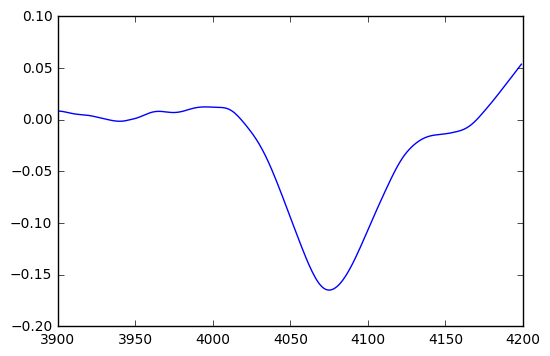

In [39]:
y = train_data_cha.ix[31].values
#y = train_data_cate.ix[42].values
x = range(3900,4200)
y=y[3900:4200]
yhat = savitzky_golay(y, 101, 3)
#plt.ylim(-2,2)
plt.plot(x,yhat) 